# Solver

In [1]:
from pathlib import Path
import os
import copy

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path(os.getcwd()) # Path(__file__) won't work in Jupyter
HERE

PosixPath('/home/naked/Documents/solver')

## Config file

In [22]:
with open(HERE / 'config' / 'settings.yaml.bak') as f:
    config = yaml.safe_load(f)
config

{'model': 'forced_vibration',
 'init_acceleration': 0,
 'init_velocity': 0,
 'init_position': 0,
 'acc_fname': 'acceleration.csv',
 'vel_fname': 'velocity.csv',
 'pos_fname': 'position.csv',
 'model_params': {'mass': 100, 'spring': 5, 'amplitude': 5, 'frequency': 3},
 'time_end': 3,
 'time_step': 1.0}

In [19]:
new_config = {
    'model'            : 'forced_vibration',
    'time_end'         : 15,
    'time_step'        : 0.1,
    'init_acceleration': 0.0,
    'init_velocity'    : 0.0,
    'init_position'    : 0.0,
    'acc_fname'        : 'acceleration.csv',
    'vel_fname'        : 'velocity.csv',
    'pos_fname'        : 'position.csv',
    'model_params': {
        "mass"     : 10,
        "spring"   : 10,
        "amplitude": 5,
        "frequency": 3,
    }
}

In [20]:
with open(HERE / 'config' / 'settings.yaml', 'w') as f:
    yaml.dump(new_config, f)

## Simulation

`cargo run` will read `config/settings.yaml` and produce:

- `result/`
  - `<config["area_fname"]>.csv`
  - `<config["ft_fname"]>.csv`

In [ ]:
!cargo run config/settings.yaml

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.01s
     Running `target/debug/solver`
ForcedVibration { condition: SolverParam { time_end: 15.0, time_step: 0.1, init_acceleration: 0.0, init_velocity: 0.0, init_position: 0.0 }, mass: 10.0, spring: 10.0, amplitude: 5.0, frequency: 3.0 }

=== Final Values v(15) ===
Euler method:        97.325493
Runge-Kutta method:  7.243610

=== Integrals x(t) = ∫v(t)dt from 0 to 15 ===
Euler ODE + Trap integration:  31.806950
RK4 ODE + Trap integration:    -30.472393



## Plot

In [10]:
def plot_data(df) -> plt:
    # plt.plot(
    #     df["timestamp"], df["analytical"],
    #     label="analytical",
    #     color="green"
    # )
    plt.plot(
        df["timestamp"], df["euler"],
        label="euler",
        color="blue",
        linestyle="--"
    )
    plt.plot(
        df["timestamp"], df["rk4"],
        label="Runge-Kutta",
        color="magenta",
        linestyle=":"
    )
    plt.legend()
    return plt

In [ ]:
# def rmse(df) -> list[float]:
#     error = {
#         "euler": 0,
#         "rk4": 0
#     }
#     for _, row in df.iterrows():
#         for method in error:
#             error[method] += (
#                 row["analytical"] - row[method]
#             ) ** 2
#     return {method: err/len(df) for method, err in error.items()}

### $a(t)$ (acceleration)

In [12]:
acc_df = pd.read_csv(
    HERE / 'result' / 'acceleration.csv'
)
acc_df

,timestamp,euler,rk4
0,0.000000,0.000000,0.000000
1,0.100000,0.050000,0.049089
2,0.200000,0.097754,0.093550
3,0.300000,0.138947,0.129423
4,0.400000,0.169795,0.153502
...,...,...,...
146,14.600019,71.665670,18.712350
147,14.700020,71.866000,20.293740
148,14.800020,71.340620,21.867410
149,14.900021,70.013430,23.421366


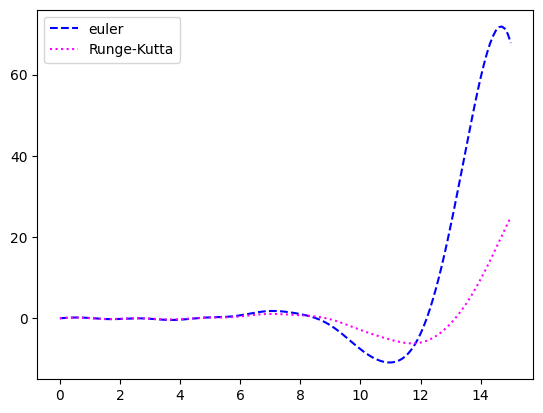

In [13]:
plot_data(acc_df).show()

### $v(t)$ (velocity: 1st integral)

In [14]:
vel_df = pd.read_csv(
    HERE / "result" / "velocity.csv",
)
vel_df

,timestamp,euler,rk4
0,0.000000,0.000000,0.000000
1,0.100000,0.050000,0.049089
2,0.200000,0.097754,0.093550
3,0.300000,0.138947,0.129423
4,0.400000,0.169795,0.153502
...,...,...,...
146,14.600019,71.665670,18.712350
147,14.700020,71.866000,20.293740
148,14.800020,71.340620,21.867410
149,14.900021,70.013430,23.421366


In [15]:
# rmse(vel_df)

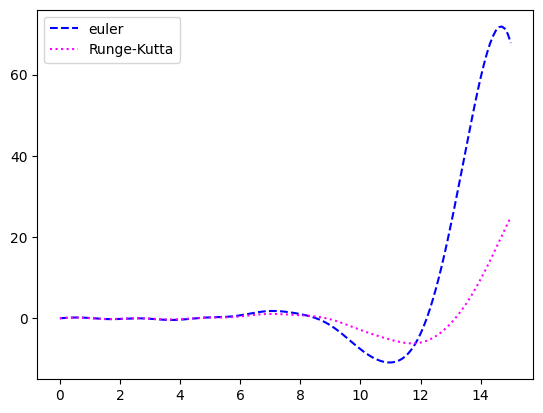

In [16]:
plot_data(vel_df).show()

### $x(t)$ (position: 2nd integral)

In [17]:
pos_df = pd.read_csv(
    HERE / "result" / "position.csv",
)
pos_df

,timestamp,euler,rk4
0,0.000000,0.000000,0.000000
1,0.100000,0.000125,0.000123
2,0.200000,0.000744,0.000725
3,0.300000,0.002325,0.002241
4,0.400000,0.005269,0.005022
...,...,...,...
146,14.600019,-1.511548,-31.543621
147,14.700020,5.750256,-31.595848
148,14.800020,13.728906,-31.445158
149,14.900021,22.418957,-31.075842


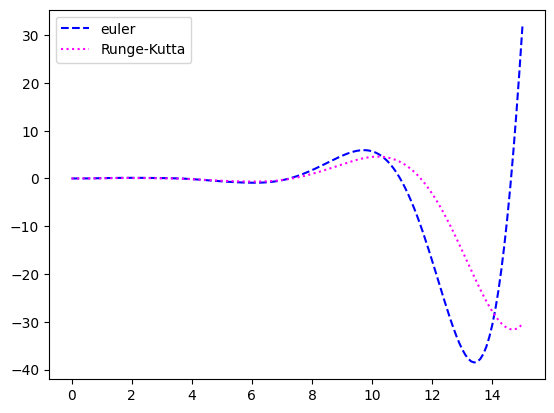

In [18]:
plot_data(pos_df).show()

## Changing timestep

In [ ]:
def plot_err(df) -> plt:
    plt.plot(
        df["timestep"], df["euler"],
        label="euler",
        color="blue",
        linestyle="--"
    )
    plt.plot(
        df["timestep"], df["rk4"],
        label="Runge-Kutta",
        color="magenta",
        linestyle=":"
    )
    plt.xscale("log")
    plt.legend()
    return plt

In [ ]:
acc_error = {
    "timestep": [],
    "euler": [],
    "rk4": [],
}
vel_error = copy.deepcopy(acc_error)
pos_error = copy.deepcopy(acc_error)

for i in range(1, 6):
    timestep = 0.1 ** i
    new_config = {
        'time_end'         : 5,
        'time_step'        : timestep,
        'init_acceleration': 0.0,
        'init_velocity'    : 0.0,
        'init_position'    : 0.0,
        'acc_fname'        : 'acceleration.csv',
        'vel_fname'        : 'velocity.csv',
        'pos_fname'        : 'position.csv',
        'model_params': {
            "mass"     : 10,
            "spring"   : 10,
            "amplitude": 5,
            "frequency": 3,
        }
    }
    with open(HERE / 'config' / 'settings.yaml', 'w') as f:
        yaml.dump(new_config, f)

    !cargo run

    acc_df = pd.read_csv(HERE / 'result' / 'acceleration.csv')
    vel_df = pd.read_csv(HERE / "result" / "velocity.csv")
    # vel_rmse = rmse(vel_df)
    pos_df = pd.read_csv(HERE / "result" / "pos.csv")

    for method in acc_error:
        if method == "timestep":
            acc_error["timestep"].append(timestep)
            vel_error["timestep"].append(timestep)
            pos_error["timestep"].append(timestep)
            continue
        vel_error[method].append(
            vel_rmse[method]
        )
        pos_error[method].append(
            pos_df.iloc[-1, -1]
            - pos_df.iloc[-1, :][method]
        )

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.02s
     Running `target/debug/solver`
Solver { time_end: 3.0, time_step: 0.1, f_0: 0.0, mass: 10.0, viscosity: 10.0, gravity: 9.8 }

=== Final Values f(3) ===
Analytical solution: 9.312087
Euler method:        9.426110
Trapezoidal method:  9.356053
Runge-Kutta method:  9.358518

=== Integrals ∫f(t)dt from 0 to 3 ===
Analytical integral:           20.087908
Euler ODE + Trap integration:  21.425200
Trap ODE + Trap integration:   20.999329
RK4 ODE + Trap integration:    21.013680

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.01s
     Running `target/debug/solver`
Solver { time_end: 3.0, time_step: 0.01, f_0: 0.0, mass: 10.0, viscosity: 10.0, gravity: 9.8 }

=== Final Values f(3) ===
Analytical solution: 9.312087
Euler method:        9.324203
Trapezoidal method:  9.316922
Runge-Kutta method:  9.316941

=== Integrals ∫f(t)dt from 0 to 3 ===
Analytical integral:           20.087891
Euler ODE + Trap in

In [ ]:
ft_err_df = pd.DataFrame(ft_error)
ft_err_df

,timestep,euler,trapezoid,rk4
0,0.10000,1.904973e-02,2.307118e-05,6.320262e-12
1,0.01000,1.879597e-04,1.985190e-09,2.735641e-12
2,0.00100,1.874642e-06,6.889929e-10,6.900937e-10
3,0.00010,4.978814e-08,5.150001e-08,5.150003e-08
4,0.00001,8.386753e-06,8.468479e-06,8.467655e-06


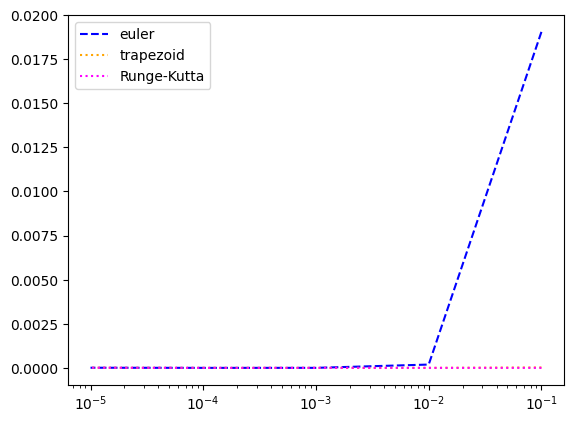

In [ ]:
plot_err(ft_err_df).show()

In [ ]:
area_err_df = pd.DataFrame(area_error)
area_err_df

,timestep,euler,trapezoid,rk4
0,0.10000,-1.337292,-0.911421,-0.925772
1,0.01000,-0.132521,-0.092961,-0.093074
2,0.00100,-0.013588,-0.009650,-0.009652
3,0.00010,-0.008839,-0.008434,-0.008434
4,0.00001,0.030857,0.030904,0.030904


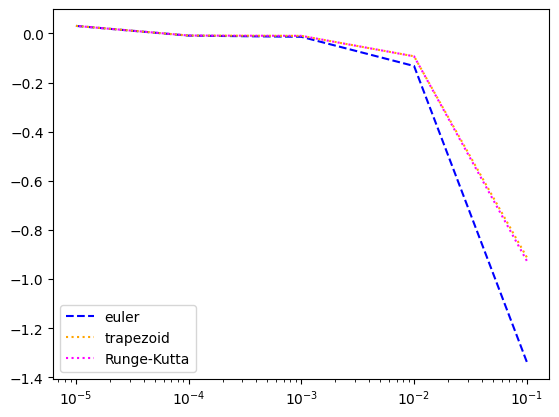

In [ ]:
plot_err(area_err_df).show()